# $\chi^2$ squared likelihood for the database

Calculating the chi squared likelihood for luminosity functions for the database of 21cmFASTv4 https://github.com/nikos-triantafyllou/Database-21cmFASTv4/tree/main <br>
**Author:** Nikolaos (Nikos) Triantafyllou<br>
**Date:** March 2025

---


In [263]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import py21cmfast_tools as p21c_tools
import py21cmfast as p21c
import os
from sklearn.neighbors import KernelDensity

plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})
plt.rcParams['lines.linewidth'] = plt.rcParamsDefault['lines.linewidth']

# plt.rc('font', size=15)          # controls default text sizes
# plt.rc('axes', titlesize=15)     # fontsize of the axes title
# plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
# plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize

import powerbox as pbox
from importlib import reload
import n_plotting
import d_plotting
import d_get_properties
import d_utils
from useful_functions.get_bardeen_PS import power_21c

In [3]:
# Load the file
# hdf = h5py.File('/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/data/id_1091.h5', 'r')
hdf = h5py.File('/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_21.h5', 'r')


# And let's see some general information
dict(hdf.attrs)

{'21cmFAST_version': '3.4.1.dev523+g33e40a87',
 'creation date/time': '2025-03-03 19:19:18.802690',
 'python_version': '3.11.6',
 'random_seed': 23,
 'redshift': 5}

## Observed UVLFs Daniela

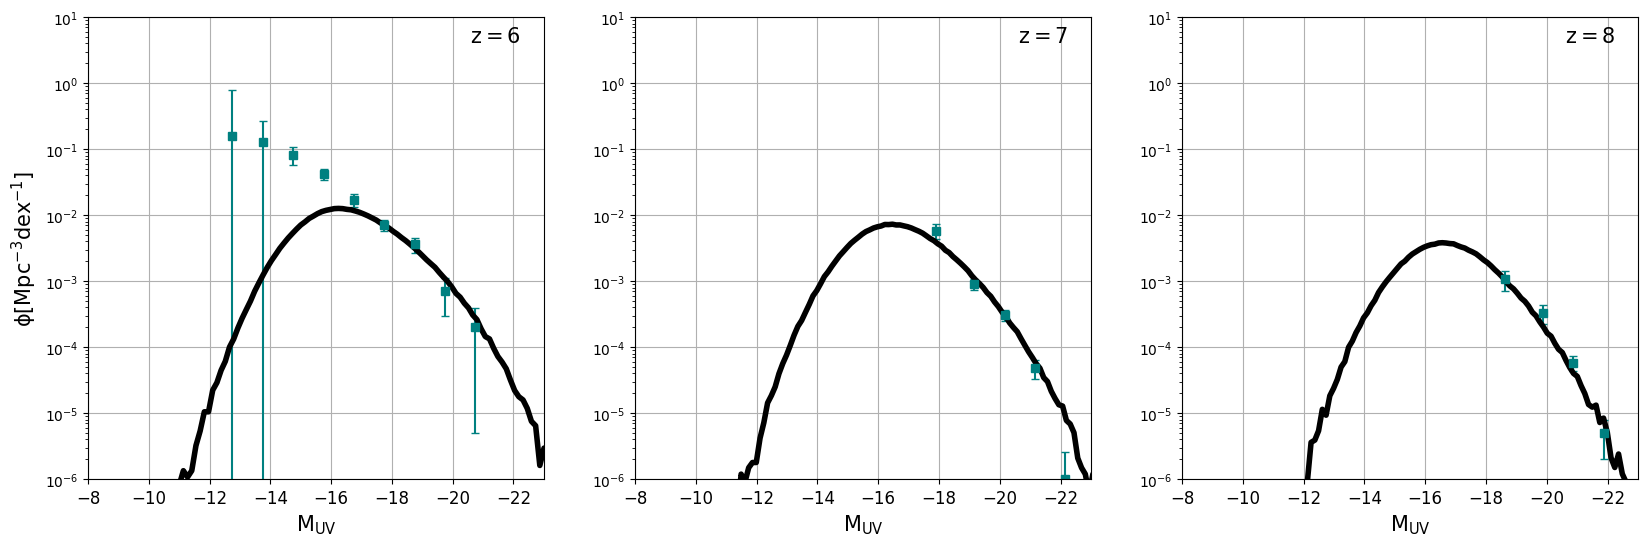

In [4]:
## UV LF ##
Muv_limits = [-23, -8]
fig, axsLF = plt.subplots(nrows = 1, ncols=3, figsize = (20,6))
for qq, redshift in enumerate([6,7,8]):
    fLF = '/home/ntriantafyllou/projects/database/UVLFs/Daniela_stuff/LFs/LF_obs_Bouwens_%.6f.txt'%(redshift)

    datainput = np.loadtxt(fLF)
    axsLF[qq].errorbar(datainput[::2,0], (datainput[::2,1]), yerr=datainput[::2,2], color='teal',fmt='s',zorder=2, capsize=3, label = 'HST observations')
    
    
    Muv, phi = d_utils.get_uvlf(redshift, hdf)
    axsLF[qq].plot(Muv, phi, color='black', linewidth =4, label = '21cmFAST')
    
    
    
    axsLF[qq].text(0.95,0.98, fr'$ \rm z={redshift} $', horizontalalignment='right',\
                  verticalalignment='top',transform=axsLF[qq].transAxes,fontsize=15)

    axsLF[qq].set_xlim(Muv_limits[::-1])
    axsLF[qq].set_ylim(1e-6,10)
    axsLF[qq].set_yscale('log')
    axsLF[qq].set_xlabel(r'$\rm M_{\rm UV}$',fontsize=15)
    axsLF[qq].xaxis.set_tick_params(labelsize=12)
    axsLF[qq].grid()


axsLF[0].set_ylabel(r"$\rm \phi [Mpc^{-3} dex^{-1}]$",fontsize=15);



# Yuxiang's EoR history

In [5]:
yxg_eor_z_arr =   [5.0, 5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0,  10.5,  11.0,  11.5,  12.0,  12.5,  13.0,  13.5, 14.0]
yxg_eor_xhi_arr = [0.0, 0.02, 0.1, 0.24, 0.38, 0.45, 0.57, 0.65, 0.73, 0.79, 0.82,  0.89,  0.91,  0.93,  0.96,  0.98,  0.99,  0.99,  1.0]

Coeval quantity shape: (92,)
Node redshifts shape: (92,)


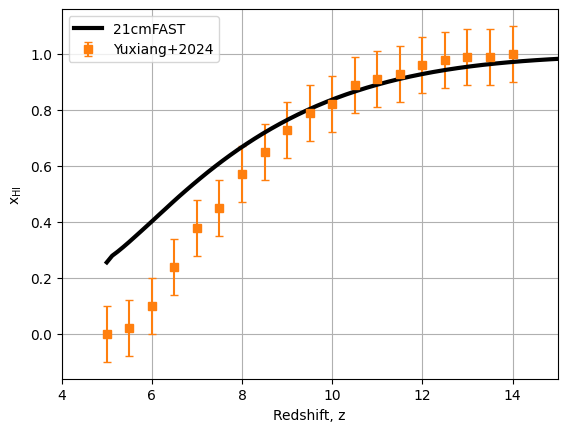

In [6]:
# Let's get the neutral fraction
x_HI_coev = hdf['coeval_data']['x_HI'][:]
print('Coeval quantity shape:', x_HI_coev.shape)

# And the redshifts corresponding to the 92 values of the previus array
node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']
print('Node redshifts shape:', node_redshifts.shape)

# Let's plot it!
fig, ax = plt.subplots()
ax.errorbar(yxg_eor_z_arr,yxg_eor_xhi_arr, yerr = 0.1, fmt='s', capsize=3, color='tab:orange', label= 'Yuxiang+2024')
ax.plot(node_redshifts, x_HI_coev, color='black', label='21cmFAST', linewidth = 3)
ax.set_xlabel('Redshift, z')
ax.set_ylabel(r'$\rm x_{HI}$')
plt.grid()


ax.set_xlim([4,15])

ax.legend()
plt.show()

---
(Note: be carreful of the difference between $\chi$ and $x$)


We want to take a $\chi^2$ effective likelihood to make our parameters match the observations. <br>
What this means is that we have a quantity, a metric, that we want to minimize, in this case $\chi^2$.<br>

Let's say we only have run 1 simulation.
We want to compare our data $y_i$ (with errors $\sigma_i$), with our model predictions $f_i(\{x\})$, where $\{x\}$ our parameter set of the simulation. We have the following expression:
    
$$ \chi^2 = \sum_i \frac{(y_i - f_i(\{x\}))^2}{\sigma_i^2}$$

If we were to run 2000 simulations, we would have 2000 $\chi^2$ and we could choose the smallest one. So for a random simulation $n$, i.e. for a parameter set $\{x\}_n$ we have:

$$ \chi^2_n = \sum_i \frac{(y_i - f_i(\{x\}_n))^2}{\sigma_i^2}$$



## But
We want to find a probability distribution for our parameters in our parameter set $\{x\}$, i.e. $P(x^1,x^2,\dots , x^{\rm total\; number \; of \; params} \; \; | \; \{y\}, \{\sigma\})$.

So we have data, i.e. all the y and all the $\sigma$. And all of our parameters x.

We can write the Bayes' theorem:

$$P(x|data)=\frac{P(data|x) \cdot P(x)}{P(data)} = \frac{\mathcal{L}(x) \cdot P(x)}{P(data)}$$


where $\mathcal{L}$ is the likelihood. 

A $\chi^2$ likelihood makes use of the $\chi^2$ quantity introduced before and can be written as:
$$\mathcal{L} \propto exp(-\chi^2/2)$$
This is essentially a gaussian likelihood where all $\sigma$ represent the standard deviation of a gaussiam around the mean $y$.


Now, the data are fixed, and I have let's say 2000 simulations, i.e. 2000 different $\{x\}$, i.e. parameters. I can now use Bayes' theorem to calculate the posterior probability of each of these combinations, since I know my likelihood. So, I know how to take a parameter set and evaluate the height of the red curve in the image below. 

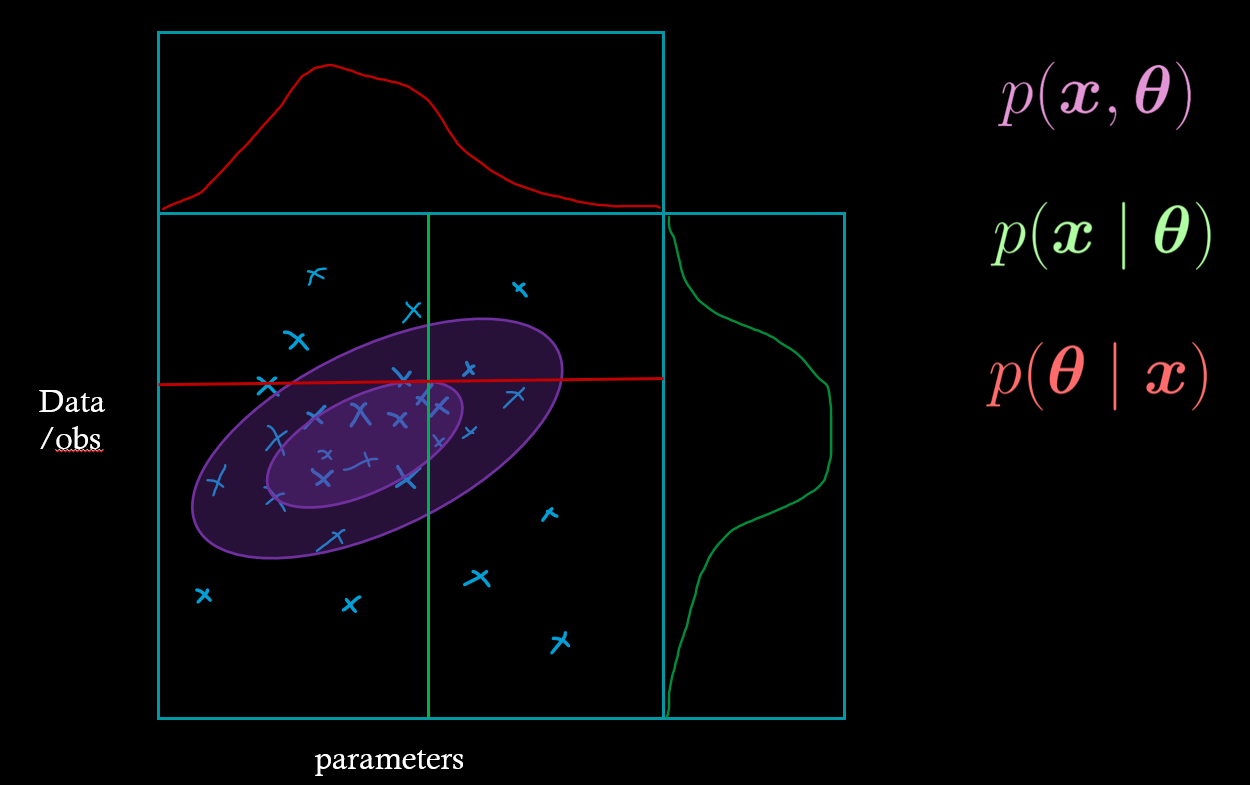

If I have run 2000 simulations I can evaluate the red curve, i.e. the posterior, at these positions. Then I can go and smooth this space with a kernel density estimation or fit a gaussian if I expect the posterior to be a gaussian. Then I will be ready to draw samples from this posterior, either by MCMC or by inverse transform sampling or anything else suitable. 

---

Now we will calculate the [f_i(x), y_i, sigma_i] and group them together

We have 19 points from xHI and 13 from UVLFs (because we take just the bright end with $M_{UV}<-17$)

In [7]:
# Get all uvlf data and save them in an array  in a cleaner(maybe) way
uvlf_x_obs = [[],[],[]] # Different sub_lists for different redshifts
uvlf_y_obs = []
uvlf_sigma_obs = []

for qq, redshift in enumerate([6,7,8]):
    fLF = '/home/ntriantafyllou/projects/database/UVLFs/Daniela_stuff/LFs/LF_obs_Bouwens_%.6f.txt'%(redshift)

    datainput = np.loadtxt(fLF)
    Muvs_obs = datainput[::2,0]
    phi_obs = datainput[::2,1]
    phi_err_obs = datainput[::2,2]
    
    for i in range(len(Muvs_obs)):
        if Muvs_obs[i]>-23 and Muvs_obs[i]<-17:
            uvlf_x_obs[qq].append(Muvs_obs[i])
            uvlf_y_obs.append(phi_obs[i])
            uvlf_sigma_obs.append(phi_err_obs[i])
            
obs_array = np.array([uvlf_y_obs,uvlf_sigma_obs])


print(obs_array)
uvlf_x_obs

[[2.000000e-04 7.000000e-04 3.600000e-03 7.100000e-03 1.000000e-06
  4.800000e-05 3.090000e-04 9.070000e-04 5.840000e-03 5.000000e-06
  5.800000e-05 3.310000e-04 1.060000e-03]
 [1.950641e-04 4.000000e-04 9.000000e-04 1.400000e-03 1.550806e-06
  1.500000e-05 6.100000e-05 1.770000e-04 1.460000e-03 3.000000e-06
  1.500000e-05 1.040000e-04 3.400000e-04]]


[[-20.75, -19.75, -18.75, -17.75],
 [-22.16, -21.16, -20.16, -19.16, -17.91],
 [-21.87, -20.87, -19.87, -18.62]]

Text(0.5, 1.0, 'All data from different redshifts in one plot')

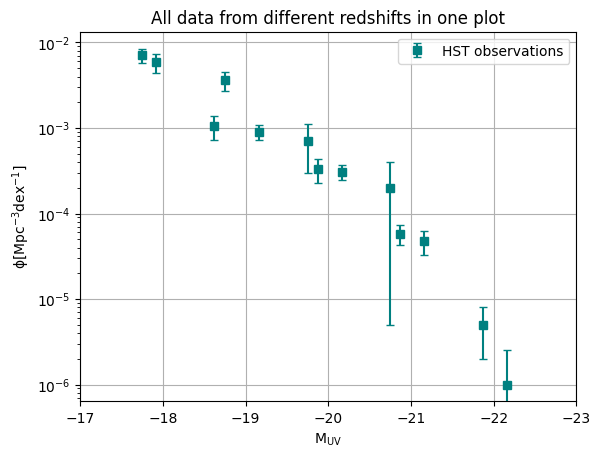

In [8]:
def flatten(xss):
    return [x for xs in xss for x in xs]
# Let's plot all of the data in the same plot
plt.errorbar(flatten(uvlf_x_obs), obs_array[0], yerr=obs_array[1], fmt='s', color='teal', label='HST observations',capsize=3)
plt.yscale('log')
plt.legend()
plt.xlim([-17,-23])
plt.grid()
plt.xlabel(r'$\rm M_{\rm UV}$')
plt.ylabel(r"$\rm \phi [Mpc^{-3} dex^{-1}]$");
plt.title(label= 'All data from different redshifts in one plot')

Our simulated data are binned and so they are discrete. We want the Muvs of our simulated data to corresponf to the Muvs of the observed ones. This doesn't matter so much but we can either (1) specify the Muv fist and then count how many halos are in a bin surrounding that Muv or (2) calculate a simulated binned UVLF and then interpolate. Here we do the second approach. One can either use nearest neighbors or linear interpolation or even higher order ones like spline etc.

In [9]:
def interpolate_obs_and_sims(x_obs, x_simed, y_simed, interpolation_type = 'NN'):
    '''
    Interpolates observed ans simualted data so that they characterize the same x values.
    
    Inputs (arrays or lists):
    - x_obs: observed positions
    - x_simed: simulated positions
    - y_simed: simulated quantities
    
    Returns (lists):
    - x_simed_corrected: Adjusted simulated x-values (matches x_obs for linear)
    - y_simed_corrected: Interpolated y-values for x_obs
    '''
    if interpolation_type == 'NN':
        x_simed_corrected = []
        y_simed_corrected = []
        for i in range(len(x_obs)):
            x_simed_corrected.append( x_simed[np.argmin(abs(x_simed-x_obs[i]))] )
            y_simed_corrected.append( y_simed[np.argmin(abs(x_simed-x_obs[i]))] ) 
            
    if interpolation_type == 'linear':
        x_simed_corrected = []
        y_simed_corrected = []
        for i in range(len(x_obs)):
            simed_id_closest = np.argmin(abs(x_simed-x_obs[i]))
            # Create fake array and make the minimum value large
            x_simed_second_closest = x_simed.copy()
            x_simed_second_closest[simed_id_closest] = 500
            simed_id_second_closest = np.argmin(abs(x_simed_second_closest-x_obs[i]))
            
            
            interpolated_y_simed = np.interp(x_obs[i], 
                      [ x_simed[simed_id_closest],x_simed[simed_id_second_closest] ], 
                      [ y_simed[simed_id_closest],y_simed[simed_id_second_closest] ])
            
            x_simed_corrected.append( x_obs[i] )
            y_simed_corrected.append(interpolated_y_simed)
       
    return x_simed_corrected, y_simed_corrected

In [10]:
# Loop through differend redshifts and create the same set like uvlf_x_obs but now uvlf_x_simed and obs_array but now simed_array

uvlf_x_simed = [[],[],[]] # Different sub_lists for different redshifts
uvlf_y_simed = []

for qq, redshift in enumerate([6,7,8]):
    Muv, phi = d_utils.get_uvlf(redshift, hdf)
    uvlf_x_simed[qq], uvlf_y_simed_qq = interpolate_obs_and_sims(uvlf_x_obs[qq], Muv, phi, 'linear')
    uvlf_y_simed+=uvlf_y_simed_qq

# obs_array = np.array([uvlf_y_obs,uvlf_sigma_obs])

Text(0.5, 1.0, 'All data from different redshifts in one plot')

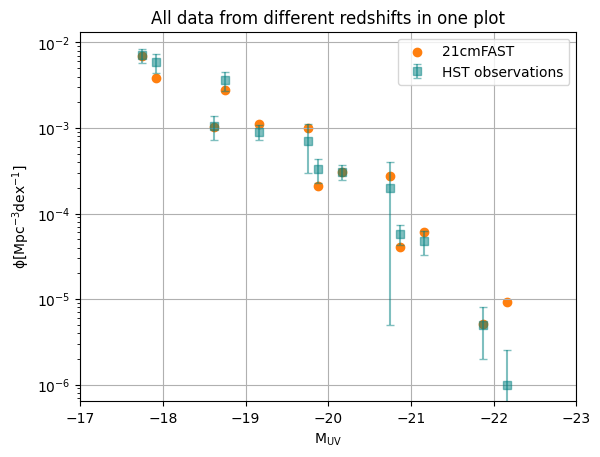

In [11]:
def flatten(xss):
    return [x for xs in xss for x in xs]
# Let's plot all of the data in the same plot
plt.errorbar(flatten(uvlf_x_obs), obs_array[0], yerr=obs_array[1], fmt='s', color='teal', label='HST observations',capsize=3, alpha=0.5)
plt.scatter(flatten(uvlf_x_simed), uvlf_y_simed, color='tab:orange', label='21cmFAST')
plt.yscale('log')
plt.legend()
plt.xlim([-17,-23])
plt.grid()
plt.xlabel(r'$\rm M_{\rm UV}$')
plt.ylabel(r"$\rm \phi [Mpc^{-3} dex^{-1}]$");
plt.title(label= 'All data from different redshifts in one plot')

## Same for XHI

In [12]:
# Find the corresponding Muvs and so the corresponding phis

yxg_eor_z_arr =   [5.0, 5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0,  10.5,  11.0,  11.5,  12.0,  12.5,  13.0,  13.5, 14.0]
yxg_eor_xhi_arr = [0.0, 0.02, 0.1, 0.24, 0.38, 0.45, 0.57, 0.65, 0.73, 0.79, 0.82,  0.89,  0.91,  0.93,  0.96,  0.98,  0.99,  0.99,  1.0]

x_HI_coev = hdf['coeval_data']['x_HI'][:]
node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']

# uvlf_x_simed[qq], uvlf_y_simed_qq = interpolate_obs_and_sims(uvlf_x_obs[qq], Muv, phi, 'linear')
simed_eor_z_arr, simed_eor_xhi_arr = interpolate_obs_and_sims(yxg_eor_z_arr[::-1], node_redshifts, x_HI_coev , 'linear')

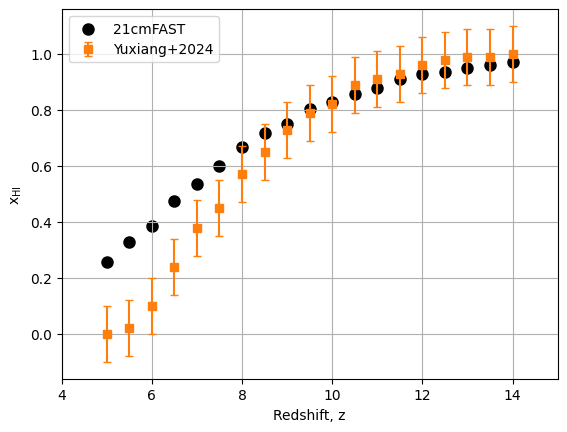

In [13]:
fig, ax = plt.subplots()
ax.errorbar(yxg_eor_z_arr,yxg_eor_xhi_arr, yerr = 0.1, fmt='s', capsize=3, color='tab:orange', label= 'Yuxiang+2024')
ax.scatter(simed_eor_z_arr, simed_eor_xhi_arr, color='black', label='21cmFAST', linewidth = 3)
ax.set_xlabel('Redshift, z')
ax.set_ylabel(r'$\rm x_{HI}$')
plt.grid()


ax.set_xlim([4,15])

ax.legend()
plt.show()

### Combine everything in a master array and compute $\chi^2$

In [14]:
# Get observed y and sigmas
y_obs = uvlf_y_obs+yxg_eor_xhi_arr
sigma_obs = uvlf_sigma_obs+list(np.ones(len(yxg_eor_xhi_arr))*0.1)

In [15]:
# Get simulated y (i.e. f)
def comlute_simuated_observables(file_id):
    hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_{file_id}.h5', 'r')

    uvlf_x_simed = [[],[],[]] # Different sub_lists for different redshifts
    uvlf_y_simed = []

    for qq, redshift in enumerate([6,7,8]):
        Muv, phi = d_utils.get_uvlf(redshift, hdf)
        uvlf_x_simed[qq], uvlf_y_simed_qq = interpolate_obs_and_sims(uvlf_x_obs[qq], Muv, phi, 'linear')
        uvlf_y_simed+=uvlf_y_simed_qq

    x_HI_coev = hdf['coeval_data']['x_HI'][:]
    node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']

    # uvlf_x_simed[qq], uvlf_y_simed_qq = interpolate_obs_and_sims(uvlf_x_obs[qq], Muv, phi, 'linear')
    simed_eor_z_arr, simed_eor_xhi_arr = interpolate_obs_and_sims(yxg_eor_z_arr, node_redshifts, x_HI_coev , 'linear')

    y_simed = uvlf_y_simed+simed_eor_xhi_arr
    
    return y_simed

y_simed = comlute_simuated_observables(21)

In [16]:
def compute_chi2(y_obs, sigma_obs, y_simed):
    chi2 = 0
    for i in range(len(y_obs)):
        chi2 += (y_obs[i] - y_simed[i])**2 / sigma_obs[i]**2
    return chi2

chi2 = compute_chi2(y_obs, sigma_obs, y_simed)
chi2

72.07581885025047

In [17]:
def compute_chi2_loglikelihood(chi2):
    return (-chi2/2)

compute_chi2_loglikelihood(chi2)

-36.037909425125235

# Trace Posterior

In [137]:
# Create a dictionary where we have {id: parameter_set, chi2}
dict_chi2 = {}

for id_i in range(21,42):
    y_simed = comlute_simuated_observables(id_i)
    hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_{id_i}.h5')
    chi2 = compute_chi2(y_obs, sigma_obs, y_simed)
    log_likelihood = compute_chi2_loglikelihood(chi2)
    
    parameters = dict(hdf['simulation_parameters']['varying_params'].attrs)
    parameters.pop('random_seed')
    dict_chi2[str(id_i)] = [parameters, chi2]
    print(log_likelihood)
    
# This part is to correct the extra parameters that my files unfortunately have only for L_X_MINI in the current run
dict_chi2['24'][0].pop('L_X_MINI')
dict_chi2['25'][0].pop('L_X_MINI')

-36.037909425125235
-30.853861263720418
-27.784762782317923
-36.92728965667457
-30.54068894176831
-34.7408523127036
-36.5248540788859
-264.5995294285913
-43291.1248617072
-64.37535162759345
-599.6406607067617
-100.88744073101522
-31.276152420633775
-60.459095327040515
-72.43644451171977
-1215.859747253451
-39.96606724211593
-26.761178228143443
-341.33316496710495
-36.31299787016869
-205.39500077074192


41.5

In [138]:
parameter_names = list(dict_chi2['21'][0].keys())
parameter_defaults = list(dict_chi2['21'][0].values())
dict_chi2['21']

[{'ALPHA_ESC': -0.5,
  'ALPHA_STAR': 0.5,
  'F_ESC10': -1.4,
  'F_STAR10': -1.3,
  'L_X': 40.5,
  'M_TURN': 5,
  'NU_X_THRESH': 500.0,
  'SIGMA_8': 0.811,
  'SIGMA_SFR_LIM': 0.19,
  't_STAR': 0.5},
 72.07581885025047]

In [139]:
parameter_names

['ALPHA_ESC',
 'ALPHA_STAR',
 'F_ESC10',
 'F_STAR10',
 'L_X',
 'M_TURN',
 'NU_X_THRESH',
 'SIGMA_8',
 'SIGMA_SFR_LIM',
 't_STAR']

In [140]:

chi2s = []
ii = 0
for i in dict_chi2.keys():
    parameter_array[:, ii] = list(dict_chi2[i][0].values())
    ii+=1
    
    chi2s.append(dict_chi2[i][1])
    
parameter_array = parameter_array.T # Shape (21, 10)
chi2_values = np.array(chi2s)  # Shape (21,)
parameter_array.shape

(21, 10)

In [141]:
log_weights = -0.5 * chi2_values
log_weights_shifted = log_weights + abs(np.max(log_weights))+15 # Add maximun and a random number (15) just to scale up the exponentials so that they don't go below machine precision

posterior_probs = []
for i in np.exp(log_weights_shifted):
    if i<1e-14:
        i = 0
    posterior_probs.append(i)
    
np.exp(log_weights_shifted)

array([3.05903228e+002, 5.45742241e+004, 1.17457325e+006, 1.25698800e+002,
       7.46442883e+004, 1.11915131e+003, 1.87977852e+002, 1.66929740e-097,
       0.00000000e+000, 1.50934764e-010, 5.20018977e-243, 2.09792742e-026,
       3.57757585e+004, 7.57875348e-009, 4.76322528e-014, 0.00000000e+000,
       6.02014284e+000, 3.26901737e+006, 7.89840186e-131, 2.32335014e+002,
       8.60466203e-072])

In [142]:
# Fit KDE with stabilized weights
kde = KernelDensity(kernel="gaussian", bandwidth='scott')  # Try "silverman" or 'scott'
kde.fit(parameter_array, sample_weight = np.exp(log_weights_shifted) )

new_samples = kde.sample(100000)  # Generate 1000 new parameter sets

My prior in this case is uniform, but I dont have enough posterior evaluations outside of this region, in which the probability should be zero. What I can do is just ignore the samples that lie outside of this distribution. 

In [143]:
# Ignore sampels outside of this distribution
def filter_samples(samples, l_bounds, u_bounds):
    """
    Filters samples to only include those within the specified bounds.

    Parameters:
        samples (np.ndarray): Input array of shape (N_samples, 10).
        l_bounds (list or np.ndarray): Lower bounds for each parameter.
        u_bounds (list or np.ndarray): Upper bounds for each parameter.

    Returns:
        np.ndarray: Filtered array containing only valid samples.
    """

    # Convert bounds to NumPy arrays (if they aren't already)
    l_bounds = np.array(l_bounds)
    u_bounds = np.array(u_bounds)

    # Create a mask to check if all values in a row satisfy the bounds
    mask = np.all((samples >= l_bounds) & (samples <= u_bounds), axis=1)

    # Apply the mask to filter valid samples
    valid_samples = samples[mask]

    return valid_samples



In [144]:
# Lower bounds in the new order
l_bounds = [
    -1,      # ALPHA_ESC
    -0.5,    # ALPHA_STAR
    -3,      # F_ESC10
    -3,      # F_STAR10
    38,      # L_X
    5,       # M_TURN
    100,     # NU_X_THRESH
    0.8092,  # SIGMA_8
    0,       # SIGMA_SFR_LIM
    0        # t_STAR
]

# Upper bounds in the new order
u_bounds = [
    0.5,     # ALPHA_ESC
    1,       # ALPHA_STAR
    0,       # F_ESC10
    0,       # F_STAR10
    42,      # L_X
    10,      # M_TURN
    1500,    # NU_X_THRESH
    0.8128,  # SIGMA_8
    1.2,     # SIGMA_SFR_LIM
    1        # t_STAR
]

valid_samples = filter_samples(new_samples, l_bounds, u_bounds)
valid_samples.shape

valid_samples = new_samples

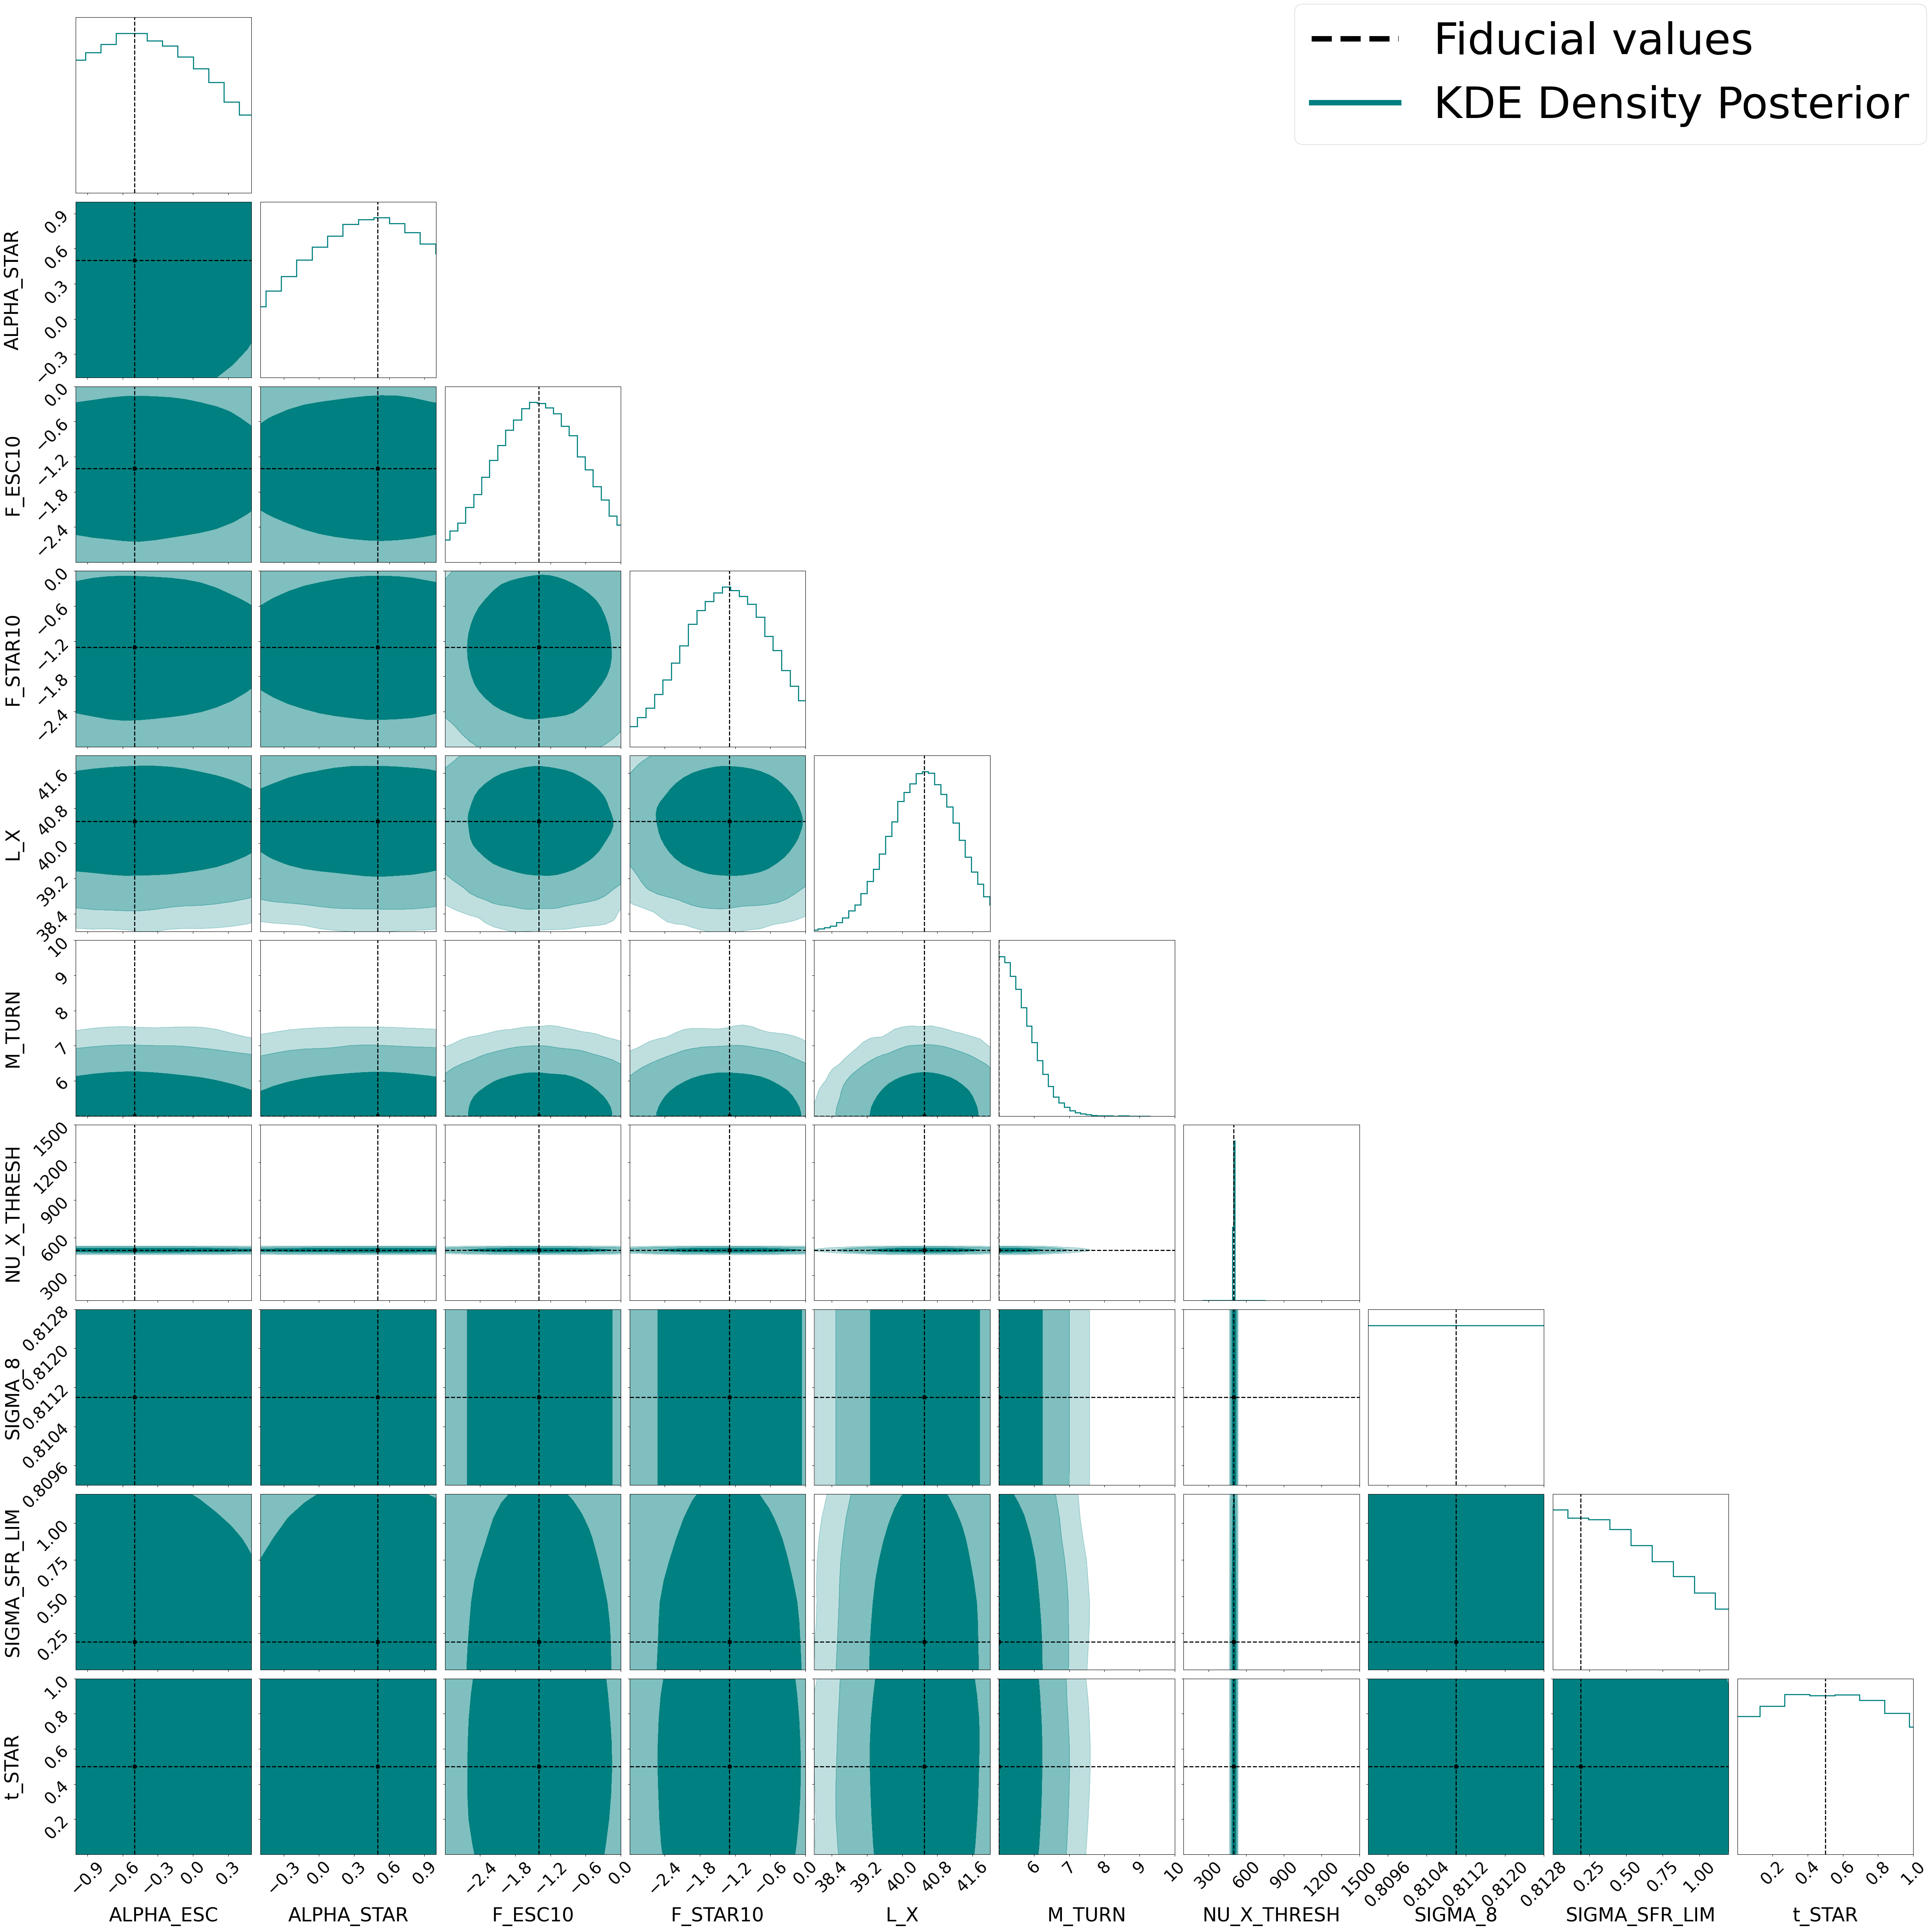

In [264]:
from corner.corner import corner
# plt.rcParams.update({'font.size': 24})
# plt.rcParams['lines.linewidth'] = 3.5

import matplotlib.lines as mlines





def cornerplot(data, fig = None, color = None, name=None, weights=None):
    fig = corner(
    data,
    bins=50,
    weights = weights, 
    fig = fig, 
    color = color, 
    levels = (0.68, 0.95, 0.99), 
    plot_contour=True,
    fill_contours=True,
    plot_density=False,
    plot_datapoints=False,
    labels = parameter_names,
    smooth=1,
    truths=parameter_defaults ,
    truth_color='black',
    linestyle='--',
    truth_kwargs={"linestyle":(0, (5, 5)), "linewidth": 1},
    label_kwargs={"fontsize": 35},
    contour_kwargs={"linestyles": "-", "alpha":0.2},
    hist_kwargs = {"linewidth": 2},
    data_kwargs={"ms": 10},
#     contourf_kwargs={"alpha": 0.1}
    )
    
    if fig is not None:
        for ax in fig.axes:
            ax.tick_params(axis="both", labelsize=30)
            
            
        #  Manually set axis limits
    if fig is not None:
        axes = np.array(fig.axes).reshape(len(l_bounds), len(l_bounds))  # Get subplot grid
        for i in range(len(l_bounds)):  
            axes[i, i].set_xlim(l_bounds[i], u_bounds[i])  # 1D histograms
            for j in range(i):
                axes[i, j].set_xlim(l_bounds[j], u_bounds[j])  # 2D scatter plots
                axes[i, j].set_ylim(l_bounds[i], u_bounds[i])  # Match y-axis limits
                
                
                
    # Manually update the linestyle of truth lines
    if fig is not None:
        for ax in fig.axes:
            for line in ax.get_lines():
                if np.all(line.get_color() == 'black'):  # Identify truth lines
                    line.set_linestyle("--")  # Force dashed truth line
                    line.set_linewidth(2)  #  Ensure visible thickness


    # Create legend handles
    legend_elements = [
        mlines.Line2D([], [], color='black', linestyle="--", linewidth=10, label="Fiducial values"),
        mlines.Line2D([], [], color=color, linestyle="-", linewidth=10, label="KDE Density Posterior")
    ]
    
    #  Add a global legend outside the plot
    fig.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, 1), fontsize=80)
    
    return fig

    

    
    
fig = plt.figure(figsize = (50, 50))
cornerplot(data = valid_samples, fig = fig, color = 'teal', name='prior');


# Plot posterior in data space

## Way #1

In [146]:
valid_samples.shape

(100000, 10)

I have 100000 samples from my posterior, I will go and find which parameters from my pre-run simulations have the closest parameters to my samples. Then I will plot luminosity functions and EoR histories that correspond to these parameters. Lastly, we will take the mean and the sigmas of these lines and plot them. 

In [147]:
# Or resample parameters
print("I have", valid_samples.shape, 'samples from my posterior')
print('I have', parameter_array.shape, 'where my simulated data are evaluated')
# That correspond to keys from list(dict_chi2.keys())[0]

I have (100000, 10) samples from my posterior
I have (21, 10) where my simulated data are evaluated


In [152]:
positions = []
for post_sample in valid_samples:
    # Make an array with the exact same dimentions as parameter_array but with the same copy of post_sample, 
    # then find the modulus for each of the parameter sets, and then save the index, the id, of the minimum modulus
    distances = np.zeros(parameter_array.shape[0])
    for i in range(parameter_array.shape[0]):
        distances[i] = np.linalg.norm(parameter_array[i] - post_sample)
    positions.append(np.argmin(distances))

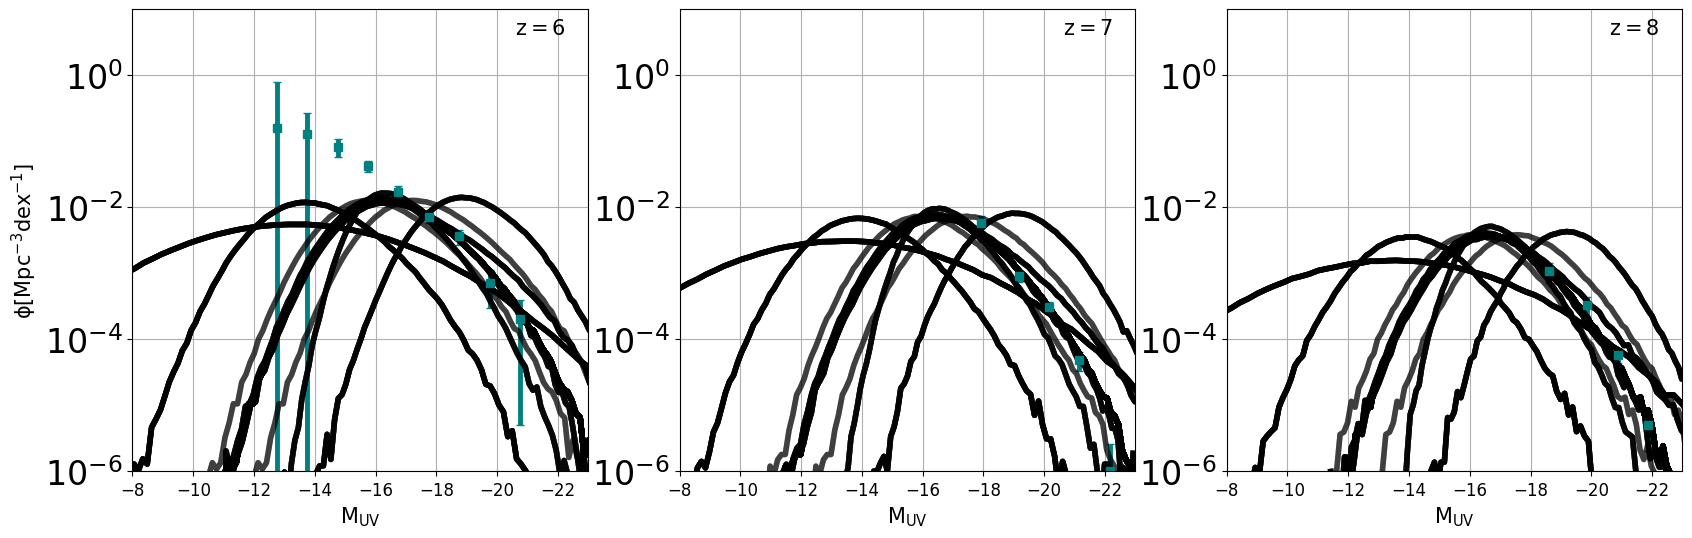

In [162]:
Muv_limits = [-23, -8]
fig, axsLF = plt.subplots(nrows = 1, ncols=3, figsize = (20,6))
for qq, redshift in enumerate([6,7,8]):
    fLF = '/home/ntriantafyllou/projects/database/UVLFs/Daniela_stuff/LFs/LF_obs_Bouwens_%.6f.txt'%(redshift)
    datainput = np.loadtxt(fLF)
    axsLF[qq].errorbar(datainput[::2,0], (datainput[::2,1]), yerr=datainput[::2,2], color='teal',fmt='s',zorder=2, capsize=3, label = 'HST observations')

    axsLF[qq].text(0.95,0.98, fr'$ \rm z={redshift} $', horizontalalignment='right',verticalalignment='top',transform=axsLF[qq].transAxes,fontsize=15)
    axsLF[qq].set_xlim(Muv_limits[::-1])
    axsLF[qq].set_ylim(1e-6,10)
    axsLF[qq].set_yscale('log')
    axsLF[qq].set_xlabel(r'$\rm M_{\rm UV}$',fontsize=15)
    axsLF[qq].xaxis.set_tick_params(labelsize=12)
    axsLF[qq].grid()
    
    
ii = 0
for ids in positions[:100]:
    print(ii, end = '\r')
    ## UV LF ##
    hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_{list(dict_chi2.keys())[ids]}.h5')
    for qq, redshift in enumerate([6,7,8]):
        Muv, phi = d_utils.get_uvlf(redshift, hdf)
        axsLF[qq].plot(Muv, phi, color='black', linewidth =4, label = '21cmFAST', alpha=0.5)

    ii+=1





axsLF[0].set_ylabel(r"$\rm \phi [Mpc^{-3} dex^{-1}]$",fontsize=15);





Actually, it takes a while to run and I think the 2nd way is a bit better...

## Way #2

Go in all simulations and plot observational data with simulated data since I know the probability of each point I go and calculate the weighted means and sigmas along the y axis at each x. 

In [226]:
posterior_probs = []
for i in np.exp(log_weights_shifted):
    if i<1e-14:
        i = 0
    posterior_probs.append(i)

In [270]:
# Get for all 3 redshifts all the phis at fixed Muvs for all simulations 
phi_array = [[], [], []]
for ids in range (21,42,1):
    hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_{ids}.h5')
    for qq, redshift in enumerate([6,7,8]):
        Muv, phi = d_utils.get_uvlf(redshift, hdf, np.linspace(-23,-8, 100))
        phi_array[qq].append(phi)


phi_array=np.array(phi_array)
print(phi_array.shape)

In [276]:
# Calculate the weighted means and sigmas for all 3 redshifts, for all phis at different Muvs and for all simulations

means = [[], [], []]
stds = [[], [], []]
for qq, redshift in enumerate([6,7,8]):
    for i in range(phi_array[qq, 0,:].shape[0]): # 99 i.e. number of Muv bins
        mean, std = d_utils.weighted_mean_std(phi_array[qq,:,i], posterior_probs)
        means[qq].append(mean)
        stds[qq].append(std)

means = np.array(means)
stds = np.array(stds)

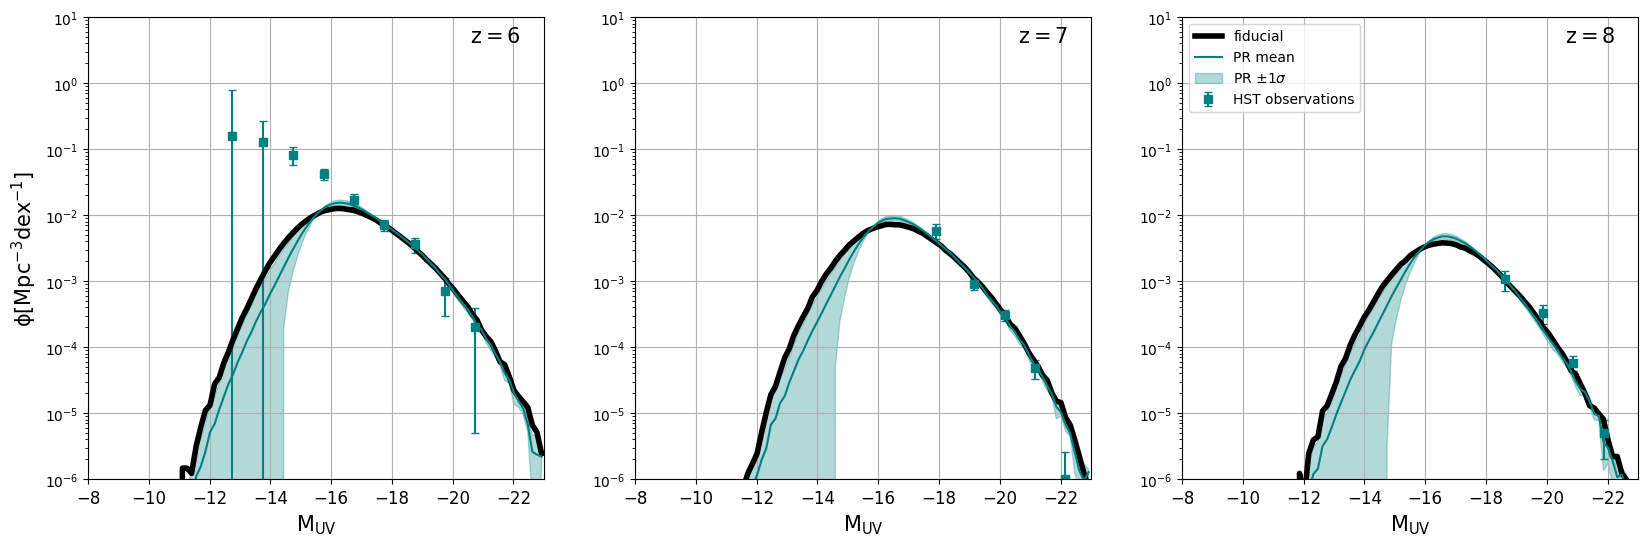

In [292]:
## UV LF ##
Muv_limits = [-23, -8]
fig, axsLF = plt.subplots(nrows = 1, ncols=3, figsize = (20,6))
for qq, redshift in enumerate([6,7,8]):
    fLF = '/home/ntriantafyllou/projects/database/UVLFs/Daniela_stuff/LFs/LF_obs_Bouwens_%.6f.txt'%(redshift)

    datainput = np.loadtxt(fLF)
    axsLF[qq].errorbar(datainput[::2,0], (datainput[::2,1]), yerr=datainput[::2,2], color='teal',fmt='s',zorder=2, capsize=3, label = 'HST observations')
    
    hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_{21}.h5')
    Muv, phi = d_utils.get_uvlf(redshift, hdf, np.linspace(-23,-8, 100))
    axsLF[qq].plot(Muv, phi, color='black', linewidth =4, label = 'fiducial')
    
    # Compute upper and lower bounds for the shaded region
    upper_bound = means[qq] + stds[qq]
    lower_bound = means[qq] - stds[qq]

    # Plot the mean line
    axsLF[qq].plot(Muv, means[qq], color='teal', label='PR mean')

    # Fill the shaded region (Mean ± Standard Deviation)
    axsLF[qq].fill_between(Muv, lower_bound, upper_bound, color='teal', alpha=0.3, label=r'PR $\pm 1\sigma$')
    
    
    
    axsLF[qq].text(0.95,0.98, fr'$ \rm z={redshift} $', horizontalalignment='right',\
                  verticalalignment='top',transform=axsLF[qq].transAxes,fontsize=15)

    axsLF[qq].set_xlim(Muv_limits[::-1])
    axsLF[qq].set_ylim(1e-6,10)
    axsLF[qq].set_yscale('log')
    axsLF[qq].set_xlabel(r'$\rm M_{\rm UV}$',fontsize=15)
    axsLF[qq].xaxis.set_tick_params(labelsize=12)
    axsLF[qq].grid()


axsLF[0].set_ylabel(r"$\rm \phi [Mpc^{-3} dex^{-1}]$",fontsize=15);
plt.legend()


where PR stands for Posterior Resimulation.

Do the same for EoR history

In [288]:
x_HI_array = []

for ids in range (21,42,1):
    hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_{ids}.h5')

    x_HI_coev = hdf['coeval_data']['x_HI'][:]
    x_HI_array.append(x_HI_coev)


node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']
x_HI_array = np.array(x_HI_array)
# Calculate the weighted means and sigmas for all 3 redshifts, for all phis at different Muvs and for all simulations


means_xhi = []
stds_xhi = []

for i in range(x_HI_array[0,:].shape[0]): # 99 i.e. number of Muv bins
    mean, std = d_utils.weighted_mean_std(x_HI_array[:,i], weights= posterior_probs)
    means_xhi.append(mean)
    stds_xhi.append(std)

means_xhi = np.array(means_xhi)
stds_xhi = np.array(stds_xhi)

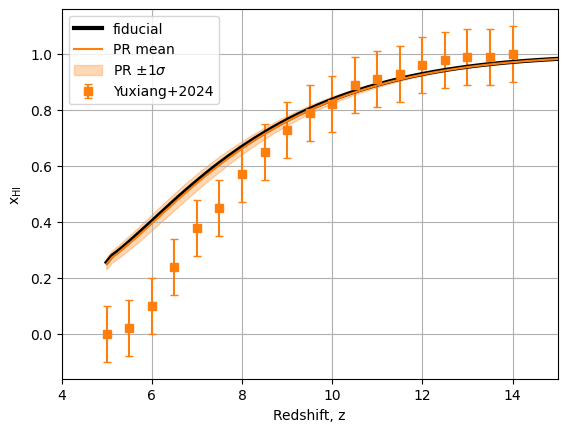

In [290]:
# Let's plot it!
upper_bound = means_xhi + stds_xhi
lower_bound = means_xhi - stds_xhi

fig, ax = plt.subplots()
ax.errorbar(yxg_eor_z_arr, yxg_eor_xhi_arr, yerr = 0.1, fmt='s', capsize=3, color='tab:orange', label= 'Yuxiang+2024')


hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_{21}.h5')
x_HI_coev = hdf['coeval_data']['x_HI'][:]
ax.plot(node_redshifts, x_HI_coev, color='black', label='fiducial', linewidth = 3)


# Plot mean and sigma
ax.plot(node_redshifts, means_xhi, color='tab:orange', label='PR mean')
ax.fill_between(node_redshifts, lower_bound, upper_bound, color='tab:orange', alpha=0.3, label=r'PR $\pm 1\sigma$')



ax.set_xlabel('Redshift, z')
ax.set_ylabel(r'$\rm x_{HI}$')
plt.grid()


ax.set_xlim([4,15])

ax.legend()
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# GARBAGE

In [238]:
# Expand to shape (21,3) by repeating along axis=1
posterior_probs_expanded = np.tile(np.array(posterior_probs)[:, np.newaxis], (1, 3))

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1556e+04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2148e+04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1615e+04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1276e+04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0940e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.1000e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0900e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.1410e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 8.4200e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 8.3680e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.1000e+03, 0.0000e+00, 0.00

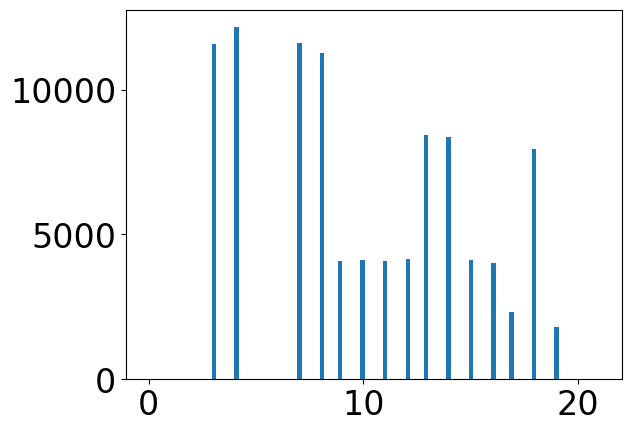

In [149]:
plt.hist(positions,range=(0,21), bins=100)

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 have no dynamic range. Please provide a `range` argument.

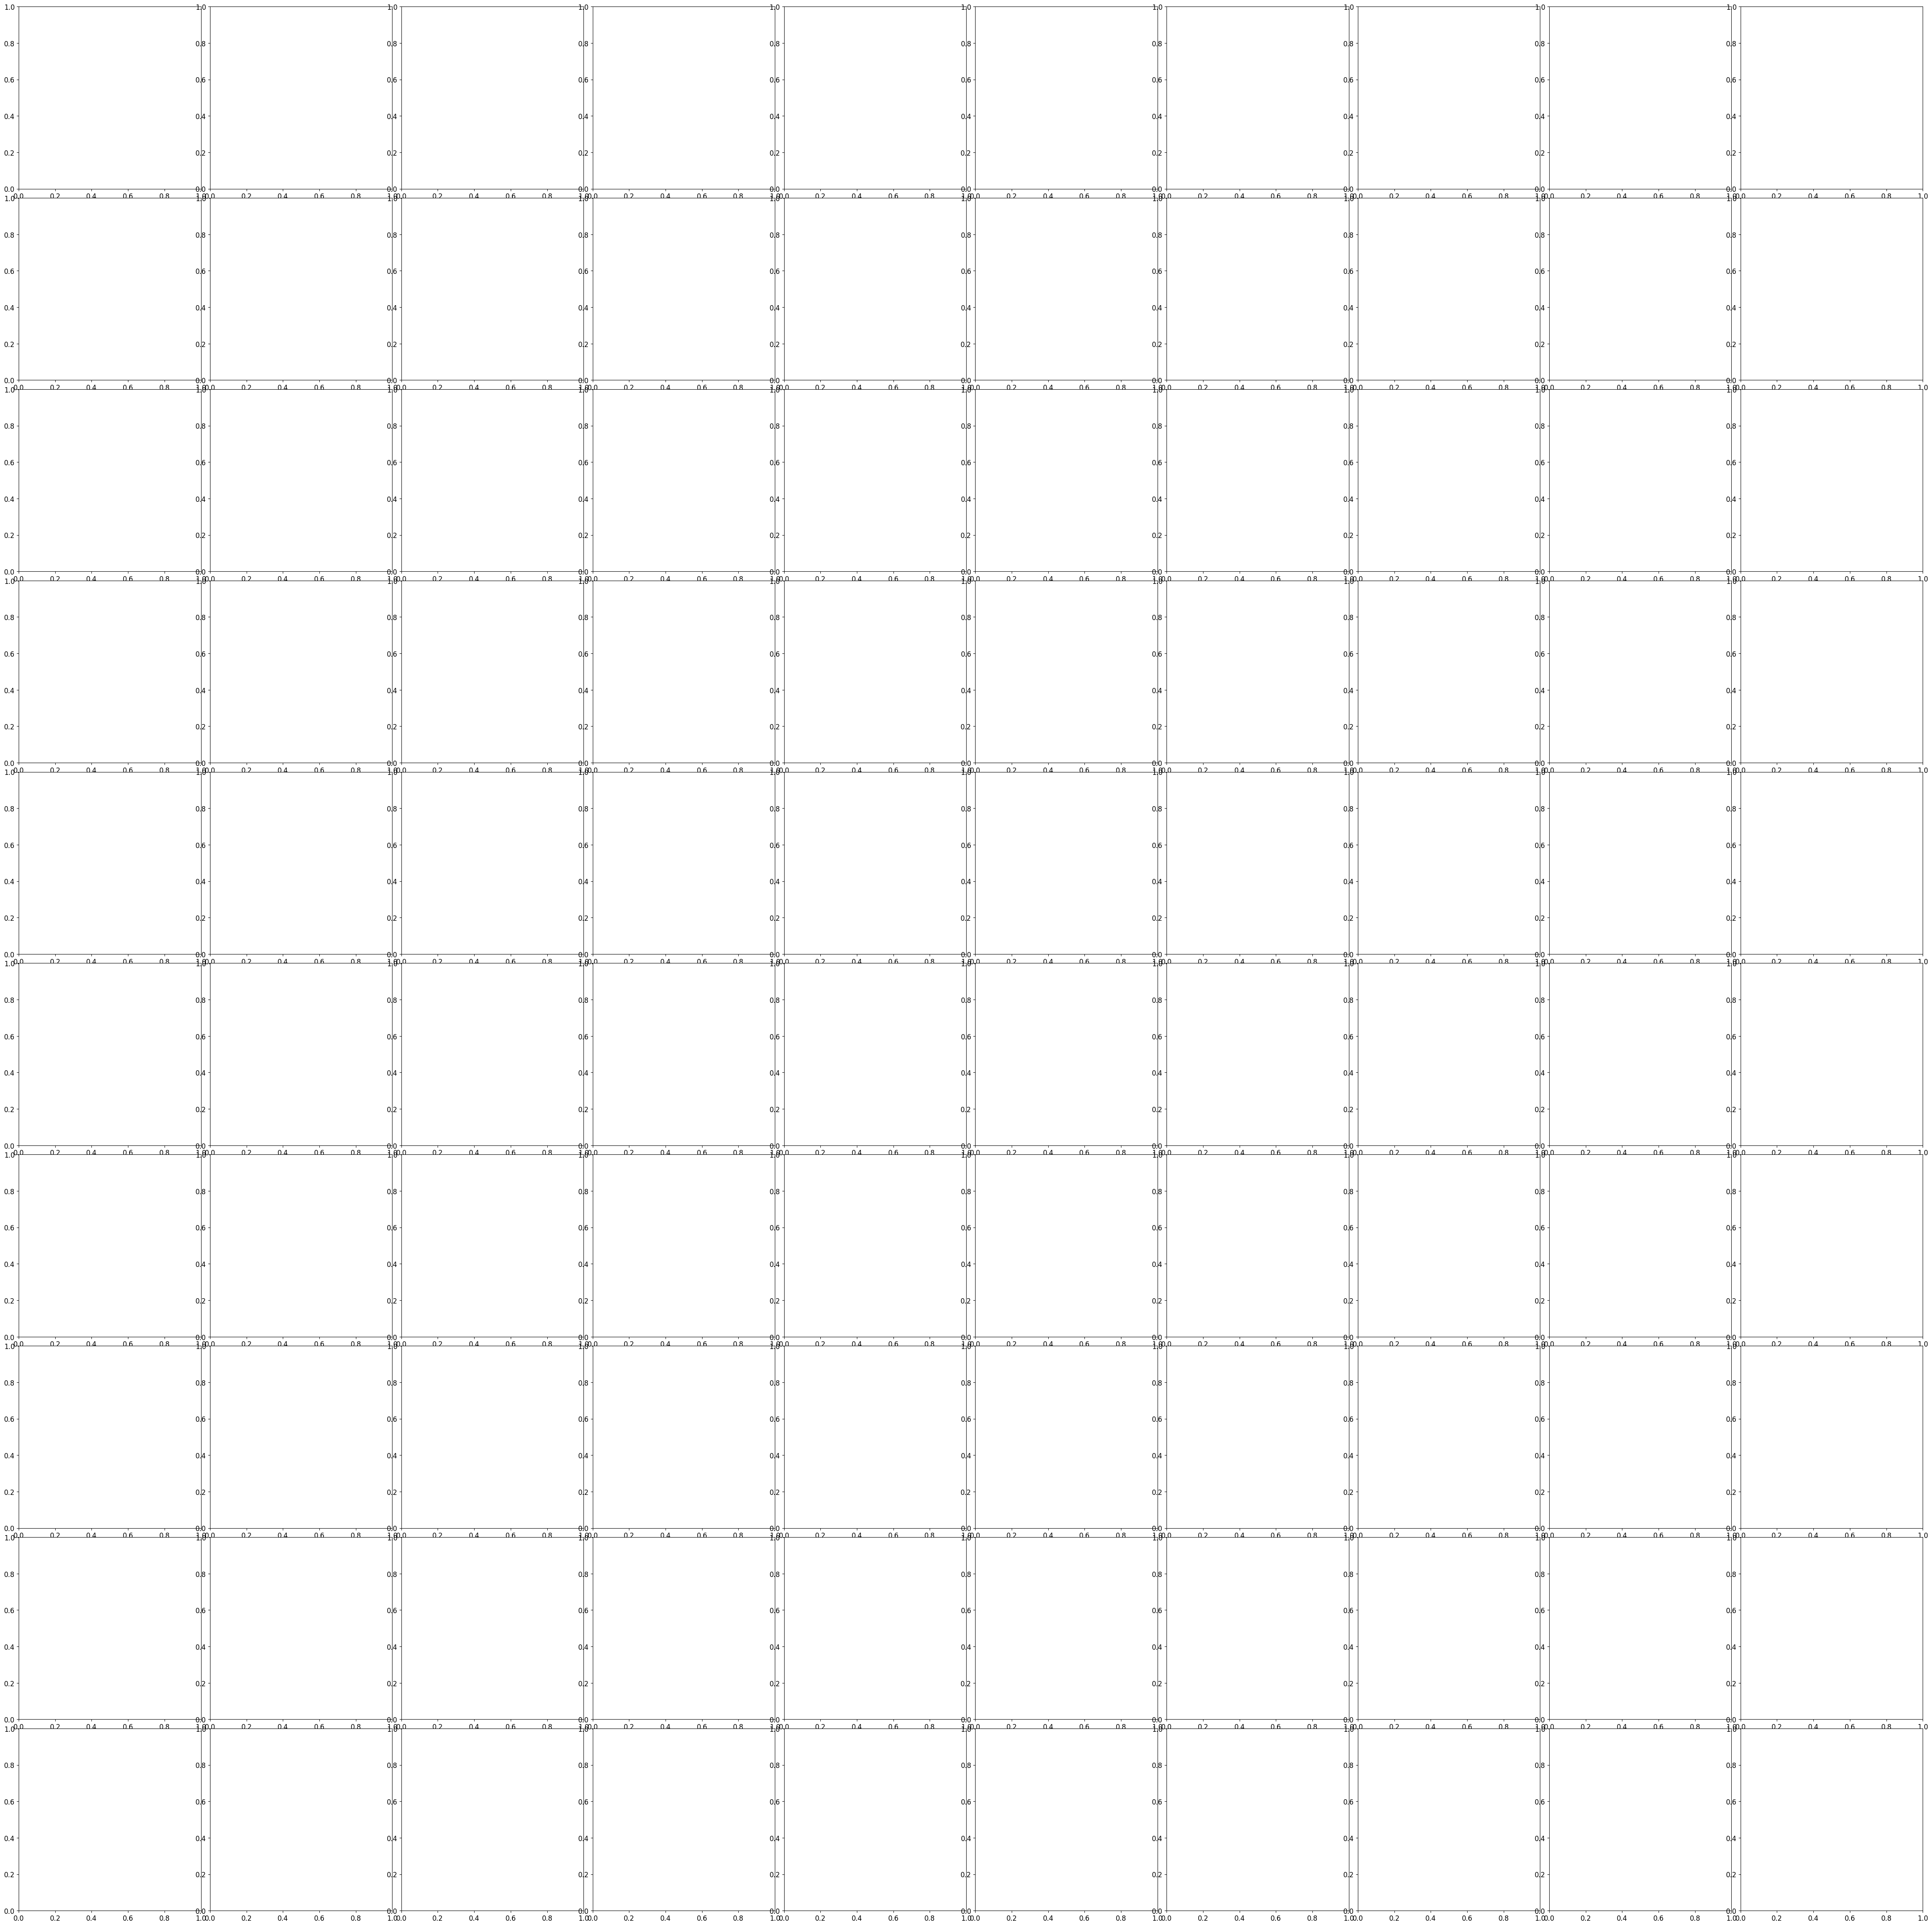

In [87]:
from corner.corner import corner

def cornerplot(data, fig = None, color = None, name=None, weights=None):
#     data = np.array(results['weighted_samples']['points'])
#     weights = np.array(results['weighted_samples']['weights'])
#     cumsumweights = np.cumsum(weights)

#     mask = cumsumweights > 1e-4

    fig = corner(
    data,
    bins=20,
    weights = weights, 
    fig = fig, 
    color = color, 
#     truths = [1.0, 1.0], 
    levels = (0.68, 0.95), 
    plot_contour=False,
    plot_density=False,
    plot_datapoints=False,
#     labels = parameter_names,
    smooth=1,
#     truths=theta_obs_list,
#     truth_color='black'
    )
    
    return fig

fig = plt.figure(figsize = (50, 50))
cornerplot(data = parameter_array.T, weights = chi2s, fig = fig, color = 'black', name='prior');

In [35]:
from sklearn.neighbors import KernelDensity
import numpy as np

# Your function values
f_values = np.array([...])  # Replace with actual computed f(x)

# Fit KDE
kde = KernelDensity(kernel='gaussian', bandwidth='scott').fit(f_values.reshape(-1, 1))

# Generate density estimates
f_grid = np.linspace(min(f_values), max(f_values), 1000).reshape(-1, 1)
log_density = kde.score_samples(f_grid)


TypeError: float() argument must be a string or a real number, not 'ellipsis'

## Observed UVLFs Yuxiang

In [44]:
from astrodatapy.number_density import number_density
from astrodatapy.correlation    import correlation
from astrodatapy.clustering     import clustering

ImportError: cannot import name 'update_default_config' from 'astropy.config.configuration' (/home/ntriantafyllou/.conda/envs/21cm-dev4/lib/python3.11/site-packages/astropy/config/configuration.py)

Text(0.5, 1.0, 'z=6')

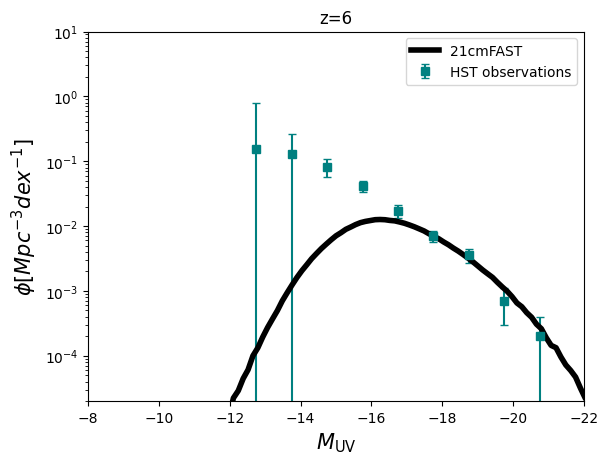

In [180]:
reload(d_utils)
# Let's plot the observations together with simulation results
which_redshift = 6
# Get observational data
fLF = '/home/ntriantafyllou/projects/database/UVLFs/Daniela_stuff/LFs/LF_obs_Bouwens_%.6f.txt'%(which_redshift)
datainput = np.loadtxt(fLF)

# Get simulation data
Muv, phi = d_utils.get_uvlf(which_redshift, hdf)


plt.errorbar(datainput[::2,0], datainput[::2,1], yerr=datainput[::2,2], fmt='s', color = 'teal',  capsize=3, label = 'HST observations')

plt.plot(Muv, phi, color='black', linewidth =4, label = '21cmFAST')


plt.yscale('log')
plt.xlim(Muv_limits[::-1])
plt.ylim(2e-5,10)
plt.xlabel(r'$M_{\rm UV}$',fontsize=15)
plt.ylabel(r"$\phi [Mpc^{-3} dex^{-1}]$",fontsize=15);
plt.legend()
plt.title(label= f'z={which_redshift}')
# axsLF[qq].xaxis.set_tick_params(labelsize=12)

In [246]:
def interpolate_obs_and_sims(x_obs, x_simed, y_simed, interpolation_type = 'NN'):
    '''
    Interpolates observed ans simualted data so that they characterize the same x values.
    
    Inputs (arrays or lists):
    - x_obs: observed positions
    - x_simed: simulated positions
    - y_simed: simulated quantities
    
    Returns (lists):
    - x_simed_corrected: Adjusted simulated x-values (matches x_obs for linear)
    - y_simed_corrected: Interpolated y-values for x_obs
    '''
    if interpolation_type == 'NN':
        x_simed_corrected = []
        y_simed_corrected = []
        for i in range(len(x_obs)):
            x_simed_corrected.append( x_simed[np.argmin(abs(x_simed-x_obs[i]))] )
            y_simed_corrected.append( y_simed[np.argmin(abs(x_simed-x_obs[i]))] ) 
            
    elif interpolation_type == 'linear':
        y_simed_corrected = list(np.interp(x_obs, x_simed, y_simed))
        x_simed_corrected = x_obs  # Linear interpolation already gives x_obs points
    
    else:
        raise ValueError("interpolation_type must be 'NN' or 'linear'")
        
    return x_simed_corrected, y_simed_corrected